# DATA GENERATION

## Import and settings
In this example, we need to import `numpy`, `pandas`, and `graphviz` in addition to `lingam`.

In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot, print_causal_directions, print_dagc

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

['1.26.4', '2.2.2', '0.20.3', '2.0.5']


## Test data
We create test data consisting of 5 variables.

         30077 function calls (30076 primitive calls) in 6.101 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    10000    3.053    0.000    3.053    0.000 {built-in method torch._C._linalg.linalg_solve}
      2/1    2.192    1.096    2.007    2.007 {built-in method builtins.exec}
     9999    0.387    0.000    0.387    0.000 {built-in method torch.matmul}
        1    0.270    0.270    2.007    2.007 1205734717.py:15(VARLiNGAM_generate)
    10000    0.194    0.000    0.194    0.000 {built-in method torch.eye}
        1    0.005    0.005    0.005    0.005 {built-in method torch.zeros}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        1    0.000    0.000    0.000    0.000 {built-in method select.select}
        1    0.000    0.000    0.000    0.000 iostream.py:127(_event_pipe_gc)
        2    0.000    0.000    0.000    0.000 tasks.py:653(sleep)
        1    0.000    0.000

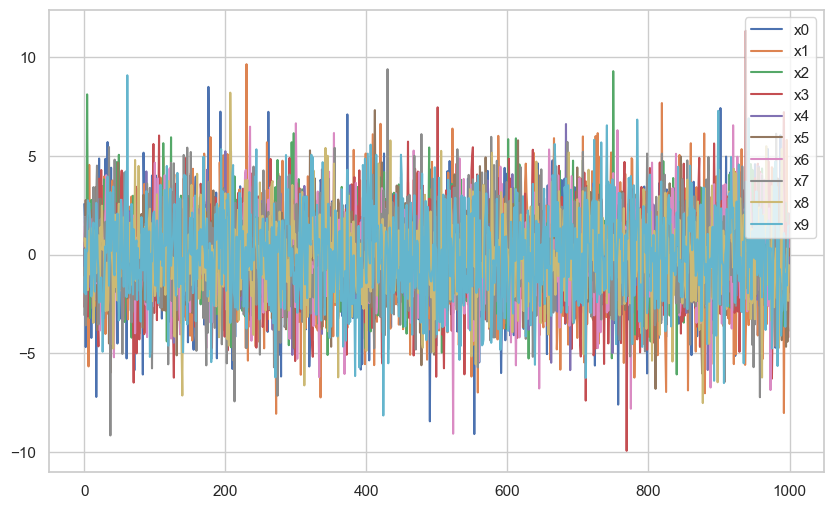

B0:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

B1:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
import cProfile



warnings.simplefilter('ignore')  # Ignore warnings
plt.rcParams["font.family"] = "MS Gothic"  # For using Japanese fonts in matplotlib

# VAR-LiNGAM artificial data generation function with PyTorch
def VARLiNGAM_generate(B0, B1, noise, device):
    n_samples, n_features = noise.shape
    
    # Initialize output tensor
    out = torch.zeros((n_samples, n_features), device=device, dtype=torch.float32)
    
    # Apply B0 to the initial noise terms
    out[0] = torch.linalg.solve(torch.eye(n_features, device=device, dtype=torch.float32) - B0, noise[0])
    
    # Generate data for subsequent time steps
    for t in range(1, n_samples):
        out[t] = torch.matmul(B1, out[t-1]) + noise[t]
        out[t] = torch.linalg.solve(torch.eye(n_features, device=device, dtype=torch.float32) - B0, out[t])
    
    return out

# Parameters
n_samples = 10000
n_features = 200

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize B0 and B1 for large dimensions
np.random.seed(0)
B0 = torch.zeros((n_features, n_features), device=device, dtype=torch.float32)
B1 = torch.zeros((n_features, n_features), device=device, dtype=torch.float32)

# Randomly generate some non-zero entries for B0 and B1 to simulate real conditions
num_connections = n_features // 50  # Adjust the sparsity
for i in range(n_features):
    indices = torch.tensor(np.random.choice(n_features, num_connections, replace=False), dtype=torch.long, device=device)
    values_B0 = torch.tensor(np.random.uniform(-0.5, 0.5, num_connections), device=device, dtype=torch.float32)
    values_B1 = torch.tensor(np.random.uniform(-0.5, 0.5, num_connections), device=device, dtype=torch.float32)
    B0[i, indices] = values_B0
    B1[i, indices] = values_B1

# Ensure B0 is a DAG by making it upper triangular
B0 = torch.triu(B0, diagonal=1)

# Generate noise
noise = torch.from_numpy(np.random.laplace(size=(n_samples, n_features)).astype(np.float32)).to(device)

# Measure elapsed time for data generation
import time
start_time = time.time()
#X_varlingam = VARLiNGAM_generate(B0, B1, noise, device)
cProfile.run('X_varlingam = VARLiNGAM_generate(B0, B1, noise, device)', sort='time')
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time for generation: {elapsed_time} seconds")

# Move data back to CPU for further processing if necessary
X_varlingam = X_varlingam.cpu().numpy()

# Create a DataFrame with the generated data
sampled_df = pd.DataFrame(data=X_varlingam[:1000], columns=[f'x{i}' for i in range(n_features)])

# Visualization
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
for i in range(min(n_features, 10)):  # Visualize only the first 10 variables to keep the plot readable
    plt.plot(sampled_df[f'x{i}'], label=f'x{i}')
plt.legend()
plt.show()

print("B0:")
print(B0)
print("\nB1:")
print(B1)
B0_groundtruth=np.array(B0)
B1_groundtruth=np.array(B1)
#cProfile.run('VARLiNGAM_generate(B0, B1, noise, device)', sort='time')

In [3]:
print("CUDA Available: ", torch.cuda.is_available())
print("CUDA Device Count: ", torch.cuda.device_count())

CUDA Available:  False
CUDA Device Count:  0


In [4]:
def find_causal_order(B):
    B = np.array(B)  # Convert tensor to NumPy array if needed
    B = B.copy()
    n = B.shape[0]
    causal_order = []

    while len(causal_order) < n:
        # Find nodes with no outgoing edges (row of all zeros)
        remaining_nodes = [i for i in range(n) if i not in causal_order]
        zero_out_degree = [i for i in remaining_nodes if np.all(B[i, :] == 0)]
        
        if len(zero_out_degree) == 0:
            raise ValueError("Graph has cycles or is not a DAG")

        # Select the first node with no outgoing edges
        node = zero_out_degree[0]
        causal_order.append(node)
        
        # Remove the node (equivalent to setting all its incoming edges to 0)
        B[:, node] = 0

    return causal_order



# Compute causal order
causal_order = find_causal_order(B0)

# # Convert indices to variable names (optional)
# variable_names = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
# causal_order_names = [variable_names[i] for i in causal_order]

print("Causal order (indices):", causal_order)
# print("Causal order (variable names):", causal_order_names)


Causal order (indices): [79, 86, 93, 94, 114, 122, 129, 130, 131, 132, 133, 137, 62, 144, 113, 53, 150, 140, 152, 154, 157, 158, 101, 162, 76, 151, 34, 74, 115, 136, 66, 103, 52, 159, 164, 165, 168, 169, 89, 135, 171, 81, 172, 175, 24, 177, 178, 180, 141, 142, 181, 65, 170, 182, 186, 147, 179, 16, 188, 143, 190, 139, 191, 149, 97, 119, 78, 187, 192, 108, 71, 156, 92, 99, 121, 120, 88, 123, 153, 61, 105, 193, 176, 96, 109, 116, 70, 167, 194, 85, 160, 36, 63, 111, 195, 163, 117, 107, 25, 82, 196, 67, 8, 189, 83, 49, 95, 35, 100, 72, 197, 38, 87, 125, 128, 134, 155, 14, 102, 6, 173, 183, 174, 32, 58, 13, 9, 185, 146, 124, 51, 68, 20, 42, 26, 55, 11, 2, 18, 29, 198, 47, 1, 161, 112, 127, 39, 57, 104, 12, 80, 145, 166, 138, 31, 19, 54, 44, 56, 90, 106, 184, 118, 5, 27, 23, 28, 110, 98, 0, 77, 45, 75, 15, 69, 4, 59, 3, 37, 73, 21, 60, 7, 17, 64, 43, 126, 30, 40, 91, 199, 48, 22, 84, 41, 148, 50, 46, 10, 33]


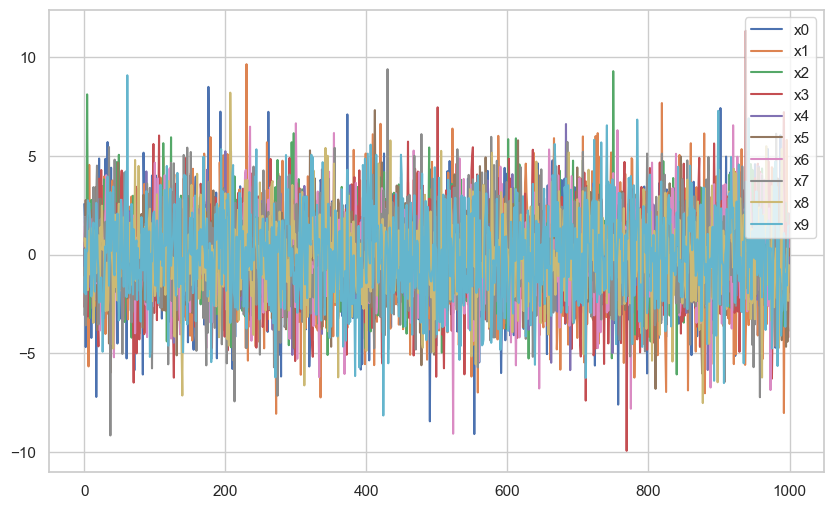

In [5]:
# If you want to visualize a small part of the data
sampled_df = pd.DataFrame(data=X_varlingam[:1000], columns=[f'x{i}' for i in range(n_features)])
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
for i in range(min(n_features, 10)):  # Visualize only the first 10 variables to keep the plot readable
    plt.plot(sampled_df[f'x{i}'], label=f'x{i}')
plt.legend()
# Save the plot as a PDF file
plt.savefig('plot.pdf')
plt.show()


In [6]:
# Create a DataFrame with the generated data (optional, might be too large to handle efficiently)
df = pd.DataFrame(data=X_varlingam, columns=[f'x{i}' for i in range(n_features)])

# Display the first 5 rows of the DataFrame (optional, might be too large to handle efficiently)
print(df.head(150))

# Save the generated data to a file (optional)
df.to_csv('varlingam_data_200.csv', index=False)


           x0        x1        x2        x3        x4        x5        x6  \
0    2.560667 -1.073020  0.609182 -2.651367 -0.582954  0.472416  0.359126   
1    1.154372  0.843618 -0.951540  1.717889  1.456035  0.554651  1.890512   
2   -4.689292 -0.365247  1.188167 -0.870910 -0.893387  2.760046  1.066860   
3    1.858163 -0.524488 -0.966904 -1.040883 -1.824558  0.490008  1.032812   
4    0.693804  2.150595  8.116385 -0.422374 -1.422640  0.316999 -0.897643   
..        ...       ...       ...       ...       ...       ...       ...   
145 -2.118163  0.905900 -0.731204  0.145433  2.613274 -1.081143  1.220159   
146  2.322173 -0.330481 -0.388064  0.406208  1.553451  0.506269 -2.455245   
147 -4.449319 -2.287211 -0.020039  2.852122  0.003160  0.936383 -0.476095   
148  0.009036  1.935272  2.965326 -0.028137  1.321143  1.260491 -1.553894   
149 -0.772905  1.593046  2.474129  0.281520 -0.374109  1.172302  0.891429   

           x7        x8        x9  ...      x190      x191      x192  \
0  

In [2]:
B0 = [
    [0,-0.12,0,0,0],
    [0,0,0,0,0],
    [-0.41,0.01,0,-0.02,0],
    [0.04,-0.22,0,0,0],
    [0.15,0,-0.03,0,0],
]
B1 = [
    [-0.32,0,0.12,0.32,0],
    [0,-0.35,-0.1,-0.46,0.4],
    [0,0,0.37,0,0.46],
    [-0.38,-0.1,-0.24,0,-0.13],
    [0,0,0,0,0],
]
causal_order = [1, 0, 3, 2, 4]

# data generated from B0 and B1
X = pd.read_csv('data/sample_data_var_lingam.csv')
#X = pd.read_csv('data/5vars_var.csv')
X

,1.471494913282564099e+00,-1.661336283782222978e+00,-9.064806694906290402e-04,2.477117513073899824e-01,1.961671354624185404e-01
0,-0.110395,0.994702,0.754015,2.268824,-1.002259
1,0.661582,-0.726295,-1.628177,-0.810560,0.446253
2,0.646422,2.641385,-1.553952,-0.349514,-0.323651
3,-1.247510,-0.489928,-0.277074,-1.482422,-0.480466
4,-0.195190,0.953328,-1.026761,0.441607,-1.251089
...,...,...,...,...,...
993,-0.743592,0.440943,-0.160168,0.611019,-0.393208
994,0.576758,-0.746436,-0.657508,0.072952,-1.253244
995,-1.428571,1.578934,0.260145,-0.598989,-0.138739
996,0.259595,0.891263,-0.752908,-0.307469,1.139200


## Causal Discovery
To run causal discovery, we create a `VARLiNGAM` object and call the `fit` method.

In [7]:
X=df
X

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x190,x191,x192,x193,x194,x195,x196,x197,x198,x199
0,2.560667,-1.073020,0.609182,-2.651367,-0.582954,0.472416,0.359126,-3.067781,0.824575,-1.914783,...,-0.544064,-1.157937,0.949864,-3.175542,0.466067,0.792903,-1.256047,0.156970,1.014973,-0.518680
1,1.154372,0.843618,-0.951540,1.717889,1.456035,0.554651,1.890512,1.897752,0.426290,0.243507,...,-0.976080,-2.231325,-0.199696,2.386914,-1.169129,-0.840276,1.915298,-0.197455,0.783628,-1.698255
2,-4.689292,-0.365247,1.188167,-0.870910,-0.893387,2.760046,1.066860,-3.589019,0.800614,-2.015999,...,-1.240202,0.216759,1.061469,-0.598357,-2.106427,0.429106,-0.084805,1.593434,-0.504895,-1.358261
3,1.858163,-0.524488,-0.966904,-1.040883,-1.824558,0.490008,1.032812,-2.563011,0.204309,0.273889,...,-1.068038,1.158047,-2.978033,-1.823879,3.389453,-0.179131,-2.942008,0.709388,-0.222507,1.523037
4,0.693804,2.150595,8.116385,-0.422374,-1.422640,0.316999,-0.897643,-1.345418,-1.020095,0.170195,...,4.426369,-1.809636,1.563643,0.398895,-0.634036,-1.638362,1.078137,0.087681,-0.925419,-1.970506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3.108449,1.218562,-2.015437,1.006168,3.627010,0.271529,1.101191,-4.302823,3.179186,-2.536968,...,0.802774,-0.855875,-5.047902,-0.301756,5.635355,1.212267,3.603527,-0.995921,-1.137633,1.354332
9996,-0.231650,3.292633,1.733571,-3.409593,-1.304378,1.102981,-2.581443,3.783198,-2.769593,-1.016734,...,-0.764746,-0.027101,-0.280393,-3.075511,2.188984,0.567036,-2.300421,-1.877916,3.805630,3.770326
9997,-0.175616,-2.062198,0.826181,-0.889419,-1.886868,2.808163,1.007312,2.162702,2.470541,0.389938,...,2.538633,-0.854599,0.223645,1.760251,1.625162,0.605700,-1.092229,-1.378460,-1.165455,-2.858336
9998,-1.385925,1.905918,1.424211,0.397938,4.408024,-0.732764,-0.048353,1.532856,-3.092564,-0.096667,...,0.333579,2.315919,-2.372317,-0.257690,0.484920,-0.298531,2.381970,-0.171084,0.709277,0.809386


In [8]:
import time
start_time = time.time()
model = lingam.VARLiNGAM()
model.fit(X)
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Estimate VAR coefficients time: 0.24204778671264648 seconds
Measure method: pwling_v2
search causal order Execution time: 12.178046464920044 seconds
estimate adjacency matrix Execution time: 20.5707528591156 seconds
Execution time: 1205.7739267349243 seconds


Using the `causal_order_` properties, we can see the causal ordering as a result of the causal discovery.

In [9]:
model.causal_order_

[93,
 164,
 186,
 182,
 193,
 150,
 122,
 181,
 197,
 114,
 154,
 198,
 180,
 162,
 194,
 191,
 187,
 168,
 97,
 192,
 133,
 132,
 94,
 142,
 157,
 169,
 135,
 144,
 113,
 53,
 196,
 190,
 85,
 199,
 195,
 185,
 152,
 137,
 62,
 188,
 176,
 79,
 156,
 61,
 160,
 131,
 175,
 184,
 106,
 170,
 173,
 151,
 76,
 159,
 189,
 161,
 145,
 163,
 117,
 107,
 67,
 127,
 172,
 167,
 84,
 148,
 96,
 116,
 140,
 171,
 81,
 141,
 158,
 86,
 108,
 165,
 39,
 139,
 146,
 177,
 126,
 40,
 149,
 91,
 119,
 118,
 124,
 68,
 42,
 26,
 121,
 101,
 51,
 65,
 130,
 178,
 183,
 109,
 134,
 71,
 50,
 46,
 33,
 92,
 99,
 63,
 153,
 105,
 120,
 88,
 8,
 24,
 36,
 98,
 136,
 70,
 103,
 83,
 20,
 89,
 30,
 143,
 66,
 48,
 55,
 174,
 129,
 112,
 57,
 104,
 80,
 155,
 125,
 100,
 72,
 41,
 102,
 115,
 78,
 6,
 77,
 75,
 73,
 45,
 64,
 15,
 4,
 123,
 87,
 14,
 47,
 22,
 1,
 12,
 25,
 34,
 74,
 11,
 29,
 5,
 49,
 27,
 23,
 28,
 110,
 38,
 128,
 32,
 52,
 21,
 10,
 111,
 58,
 82,
 60,
 17,
 18,
 7,
 0,
 13,
 9,
 2,
 17

Also, using the `adjacency_matrices_` properties, we can see the adjacency matrix as a result of the causal discovery.

In [10]:
# B0
B0_result=model.adjacency_matrices_[0]

In [11]:
B0_result

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
# B1
B1_result=model.adjacency_matrices_[1]
B1_result

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
model.residuals_

array([[ 1.741,  0.269, -0.018, ...,  0.294,  0.599, -0.52 ],
       [-4.35 , -1.579,  0.522, ...,  0.647, -1.308, -1.137],
       [ 1.233, -2.247, -0.994, ...,  0.901, -0.779,  1.525],
       ...,
       [-0.919,  0.167,  1.255, ..., -1.754, -1.431, -2.477],
       [-2.504,  2.13 ,  0.65 , ..., -0.467,  0.695, -0.818],
       [ 0.257, -0.146, -0.031, ...,  0.117,  0.592,  1.4  ]],
      dtype=float32)

Using `DirectLiNGAM` for the `residuals_` properties, we can calculate B0 matrix.

In [15]:
dlingam = lingam.DirectLiNGAM()
dlingam.fit(model.residuals_)
dlingam.adjacency_matrix_

Measure method: pwling


KeyboardInterrupt: 

In [14]:
import numpy as np

def precision_recall_f1(matrix1, matrix2):
    assert matrix1.shape == matrix2.shape, "Matrices must have the same shape"
    
    # Convert matrices to boolean: True for non-zero, False for zero
    bool_matrix1 = matrix1 != 0
    bool_matrix2 = matrix2 != 0
    
    # Calculate True Positives (TP), False Positives (FP), False Negatives (FN), True Negatives (TN)
    TP = np.sum(np.logical_and(bool_matrix1, bool_matrix2))
    FP = np.sum(np.logical_and(np.logical_not(bool_matrix1), bool_matrix2))
    FN = np.sum(np.logical_and(bool_matrix1, np.logical_not(bool_matrix2)))
    TN = np.sum(np.logical_and(np.logical_not(bool_matrix1), np.logical_not(bool_matrix2)))
    
    # Compute precision, recall, and f1-score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1_score

# Example usage
#B0_groundtruth = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
#B0_result = np.array([[1, 0, 1], [0, 1, 0], [0, 0, 1]])

precision_B0, recall_B0, f1_score_B0 = precision_recall_f1(B0_groundtruth, B0_result)
print(f"Precision B0: {precision_B0}")
print(f"Recall B0: {recall_B0}")
print(f"F1-score B0: {f1_score_B0}")

#B1_groundtruth = np.array([[1, 1, 0], [0, 1, 1], [1, 0, 1]])
#B1_result = np.array([[1, 0, 1], [1, 1, 0], [0, 0, 1]])

precision_B1, recall_B1, f1_score_B1 = precision_recall_f1(B1_groundtruth, B1_result)
print(f"Precision B1: {precision_B1}")
print(f"Recall B1: {recall_B1}")
print(f"F1-score B1: {f1_score_B1}")


Precision B0: 0.9889196675900277
Recall B0: 0.946949602122016
F1-score B0: 0.9674796747967479
Precision B1: 0.9855832241153342
Recall B1: 0.94
F1-score B1: 0.9622520793346129


In [16]:
# Compute the structural hamming distance
def structural_hamming_distance(matrix1, matrix2):
    assert matrix1.shape == matrix2.shape, "Matrices must have the same shape"
    
    # Convert matrices to boolean: True for non-zero, False for zero
    bool_matrix1 = matrix1 != 0
    bool_matrix2 = matrix2 != 0
    
    # Compute the Hamming distance
    distance = np.sum(bool_matrix1 != bool_matrix2)
    
    return distance

shd_B0 = structural_hamming_distance(B0_groundtruth, B0_result)
print(B0_groundtruth)
print(B0_result)
print(f"Structual Hamming Distance of B0: {shd_B0}")

shd_B1 = structural_hamming_distance(B1_groundtruth, B1_result)
print(f"Structual Hamming Distance of B1: {shd_B1}")

error_rate_B0=shd_B0/n_features**2
error_rate_B1=shd_B1/n_features**2
print(f"Error rate B0: {error_rate_B0}")
print(f"Error rate B1: {error_rate_B1}")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Structual Hamming Distance of B0: 26
Structual Hamming Distance of B1: 59
Error rate B0: 0.00065
Error rate B1: 0.001475


We can draw a causal graph by utility funciton.

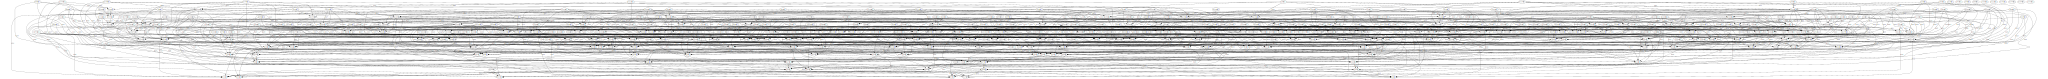

In [18]:
#labels = ['x0(t)', 'x1(t)', 'x2(t)', 'x3(t)', 'x4(t)', 'x0(t-1)', 'x1(t-1)', 'x2(t-1)', 'x3(t-1)', 'x4(t-1)']
#labels = ['x0(t)', 'x1(t)', 'x2(t)', 'x3(t)', 'x0(t-1)', 'x1(t-1)', 'x2(t-1)', 'x3(t-1)']
#labels = ['x0(t)', 'x1(t)', 'x2(t)', 'x3(t)', 'x4(t)', 'x5(t)', 'x0(t-1)', 'x1(t-1)', 'x2(t-1)', 'x3(t-1)', 'x4(t-1)', 'x5(t-1)']
labels = [f'x{i}(t)' for i in range(n_features)] + [f'x{i}(t-1)' for i in range(n_features)]
dot = make_dot(np.hstack(model.adjacency_matrices_), ignore_shape=True, lower_limit=0.05, labels=labels)


# Save pdf
dot.render('dag')

# Save png
dot.format = 'png'
dot.render('dag')

dot

## Independence between error variables
To check if the LiNGAM assumption is broken, we can get p-values of independence between error variables. The value in the i-th row and j-th column of the obtained matrix shows the p-value of the independence of the error variables $e_i$ and $e_j$.

In [74]:
p_values = model.get_error_independence_p_values()
print(p_values)

[[0.    0.59  0.022 0.365 0.067 0.012]
 [0.59  0.    0.401 0.393 0.083 0.493]
 [0.022 0.401 0.    0.166 0.658 0.544]
 [0.365 0.393 0.166 0.    0.069 0.485]
 [0.067 0.083 0.658 0.069 0.    0.751]
 [0.012 0.493 0.544 0.485 0.751 0.   ]]


## Bootstrap

### Bootstrapping
We call `bootstrap()` method instead of `fit()`. Here, the second argument specifies the number of bootstrap sampling.

In [47]:
model = lingam.VARLiNGAM()
result = model.bootstrap(X, n_sampling=100)

## Causal Directions
Since `BootstrapResult` object is returned, we can get the ranking of the causal directions extracted by `get_causal_direction_counts()` method. In the following sample code, `n_directions` option is limited to the causal directions of the top 8 rankings, and `min_causal_effect` option is limited to causal directions with a coefficient of 0.3 or more.

In [48]:
cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.3, split_by_causal_effect_sign=True)

We can check the result by utility function.

In [49]:
print_causal_directions(cdc, 100, labels=labels)

x5(t) <--- x5(t-1) (b<0) (100.0%)
x0(t) <--- x0(t-1) (b<0) (100.0%)
x4(t) <--- x2(t-1) (b>0) (100.0%)
x0(t) <--- x3(t-1) (b<0) (100.0%)
x4(t) <--- x3(t-1) (b<0) (99.0%)
x2(t) <--- x5(t-1) (b>0) (98.0%)
x2(t) <--- x2(t-1) (b<0) (98.0%)
x5(t) <--- x4(t-1) (b>0) (98.0%)


## Directed Acyclic Graphs
Also, using the `get_directed_acyclic_graph_counts()` method, we can get the ranking of the DAGs extracted. In the following sample code, `n_dags` option is limited to the dags of the top 3 rankings, and `min_causal_effect` option is limited to causal directions with a coefficient of 0.2 or more.

In [50]:
dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.2, split_by_causal_effect_sign=True)

We can check the result by utility function.

In [51]:
print_dagc(dagc, 100, labels=labels)

DAG[0]: 3.0%
	x0(t) <--- x1(t) (b>0)
	x0(t) <--- x4(t) (b>0)
	x0(t) <--- x0(t-1) (b<0)
	x0(t) <--- x1(t-1) (b>0)
	x0(t) <--- x3(t-1) (b<0)
	x0(t) <--- x4(t-1) (b<0)
	x1(t) <--- x1(t-1) (b<0)
	x1(t) <--- x2(t-1) (b>0)
	x2(t) <--- x0(t) (b>0)
	x2(t) <--- x1(t) (b<0)
	x2(t) <--- x4(t) (b>0)
	x2(t) <--- x0(t-1) (b>0)
	x2(t) <--- x1(t-1) (b<0)
	x2(t) <--- x2(t-1) (b<0)
	x2(t) <--- x3(t-1) (b>0)
	x2(t) <--- x5(t-1) (b>0)
	x3(t) <--- x0(t) (b>0)
	x3(t) <--- x4(t) (b>0)
	x3(t) <--- x5(t) (b>0)
	x3(t) <--- x3(t-1) (b>0)
	x3(t) <--- x4(t-1) (b>0)
	x4(t) <--- x0(t-1) (b>0)
	x4(t) <--- x1(t-1) (b<0)
	x4(t) <--- x2(t-1) (b>0)
	x4(t) <--- x3(t-1) (b<0)
	x4(t) <--- x5(t-1) (b<0)
	x5(t) <--- x1(t-1) (b<0)
	x5(t) <--- x2(t-1) (b>0)
	x5(t) <--- x3(t-1) (b<0)
	x5(t) <--- x4(t-1) (b>0)
	x5(t) <--- x5(t-1) (b<0)
DAG[1]: 2.0%
	x0(t) <--- x1(t) (b>0)
	x0(t) <--- x3(t) (b>0)
	x0(t) <--- x4(t) (b>0)
	x0(t) <--- x0(t-1) (b<0)
	x0(t) <--- x1(t-1) (b>0)
	x0(t) <--- x3(t-1) (b<0)
	x0(t) <--- x4(t-1) (b<0)
	x1(t) <

## Probability
Using the `get_probabilities()` method, we can get the probability of bootstrapping.

In [52]:
prob = result.get_probabilities(min_causal_effect=0.1)
print('Probability of B0:\n', prob[0])
print('Probability of B1:\n', prob[1])

Probability of B0:
 [[0.   0.78 0.05 0.44 0.96 0.09]
 [0.22 0.   0.03 0.44 0.93 0.37]
 [0.58 0.48 0.   0.64 0.92 0.51]
 [0.56 0.4  0.14 0.   0.98 0.73]
 [0.   0.07 0.02 0.   0.   0.34]
 [0.15 0.   0.04 0.24 0.08 0.  ]]
Probability of B1:
 [[1.   1.   0.68 1.   1.   0.78]
 [0.26 0.82 0.92 0.37 0.8  0.22]
 [1.   1.   1.   0.99 0.47 0.99]
 [0.59 0.83 0.19 0.68 0.9  0.21]
 [0.99 0.98 1.   1.   0.14 1.  ]
 [0.42 1.   0.99 1.   1.   1.  ]]


## Total Causal Effects
Using the `get_causal_effects()` method, we can get the list of total causal effect. The total causal effects we can get are dictionary type variable.
We can display the list nicely by assigning it to pandas.DataFrame. Also, we have replaced the variable index with a label below.

In [53]:
causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)
df = pd.DataFrame(causal_effects)

df['from'] = df['from'].apply(lambda x : labels[x])
df['to'] = df['to'].apply(lambda x : labels[x])
df

,from,to,effect,probability
0,x5(t-1),x5(t),-0.440285,1.00
1,x4(t),x3(t),0.556299,1.00
2,x2(t-1),x2(t),-0.192373,1.00
3,x1(t-1),x2(t),-0.463710,1.00
4,x0(t-1),x2(t),0.280772,1.00
...,...,...,...,...
59,x0(t),x5(t),-0.003457,0.16
60,x2(t),x5(t),-0.055661,0.11
61,x1(t),x4(t),-0.172976,0.07
62,x2(t),x1(t),0.066430,0.07


We can easily perform sorting operations with pandas.DataFrame.

In [54]:
df.sort_values('effect', ascending=False).head()

,from,to,effect,probability
51,x3(t),x0(t),0.659883,0.44
34,x4(t),x2(t),0.599901,0.98
63,x2(t),x4(t),0.580110,0.02
40,x1(t),x0(t),0.563607,0.78
1,x4(t),x3(t),0.556299,1.00


And with pandas.DataFrame, we can easily filter by keywords. The following code extracts the causal direction towards x1(t).

In [55]:
df[df['to']=='x1(t)'].head()

,from,to,effect,probability
11,x4(t-1),x1(t),-0.139057,1.00
13,x2(t-1),x1(t),0.225308,1.00
14,x1(t-1),x1(t),-0.162785,1.00
16,x0(t-1),x1(t),-0.069338,1.00
35,x4(t),x1(t),-0.190283,0.93


Because it holds the raw data of the total causal effect (the original data for calculating the median), it is possible to draw a histogram of the values of the causal effect, as shown below.

(array([ 4.,  9., 10., 14., 15., 11., 13., 11.,  9.,  4.]),
 array([-0.533, -0.519, -0.504, -0.49 , -0.476, -0.462, -0.447, -0.433,
        -0.419, -0.404, -0.39 ]),
 <BarContainer object of 10 artists>)

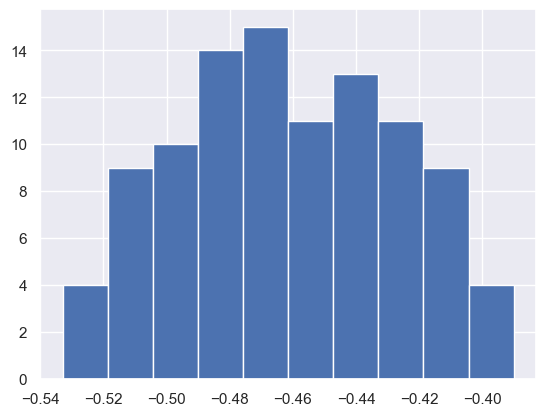

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from_index = 7 # index of x2(t-1). (index:2)+(n_features:5)*(lag:1) = 7
to_index = 2 # index of x2(t). (index:2)+(n_features:5)*(lag:0) = 2
plt.hist(result.total_effects_[:, to_index, from_index])